# Install and Import Libraries
We start by installing the required packages (`ucimlrepo`, `scikit-learn`, `pandas`, `matplotlib`, `seaborn`, `imbalanced-learn`) and importing the necessary libraries for data loading, preprocessing, modeling, and evaluation.


In [15]:
!pip install ucimlrepo scikit-learn pandas matplotlib seaborn imbalanced-learn kagglehub[pandas-datasets]



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
import seaborn as sns
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE 
import kagglehub

/home/ludmila/Random-Forest/myvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the Dataset
We fetch the Breast Cancer Wisconsin dataset from the UCI Machine Learning Repository using `ucimlrepo`. 
The dataset contains features computed from breast mass images, and the target variable is the diagnosis (`M = Malignant, B = Benign`).
We also visualize the distribution of the target variable.

**Important Note:**  
The original dataset used in this project was the *Breast Cancer Wisconsin (Diagnostic)* dataset hosted on the UCI Machine Learning Repository.  
During the experiment, the UCI server became temporarily unavailable, which prevented `ucimlrepo` from accessing the dataset.

To ensure continuity and reproducibility, we switched to the equivalent dataset provided directly by scikit-learn (`load_breast_cancer`).  
Both datasets originate from the same source (Dr. Wolberg, University of Wisconsin Hospital) and contain the same diagnostic measurements.  
The scikit-learn version is a cleaned and standardized version of the UCI dataset (same features, same samples, only differences are column naming and removal of the ID column).  

Therefore, using the scikit-learn dataset does **not** change the nature of the analysis or the validity of the results.


In [ ]:
# Download latest version : no need to execute this line since I pushed the data s
path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")

print("Path to dataset files:", path)

100%|██████████| 48.6k/48.6k [00:00<00:00, 296kB/s]

Extracting files...


Path to dataset files: /home/ludmila/.cache/kagglehub/datasets/uciml/breast-cancer-wisconsin-data/versions/2


In [2]:
# Set the path to our CSV dataset
file_path = "datasets/data.csv"

# Load the CSV into a DataFrame
df = pd.read_csv(file_path)

# Quick look at first 5 rows
print("First 5 records:")
print(df.head())

# Separate features and target
X = df.drop(columns=['diagnosis'])  # the target column is 'diagnosis'
y = df['diagnosis']

# Optional: check the feature names
print("Feature columns:", X.columns.tolist())


First 5 records:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_

In [3]:
list(y.unique())

['M', 'B']

In [4]:
# Quick look
print("Feature head:")
print(X.head())

print("\nTarget distribution:")
print(y.value_counts())

# print("\nMetadata:")
# print(breast_cancer_wisconsin.metadata)

Feature head:
         id  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302        17.99         10.38          122.80     1001.0   
1    842517        20.57         17.77          132.90     1326.0   
2  84300903        19.69         21.25          130.00     1203.0   
3  84348301        11.42         20.38           77.58      386.1   
4  84358402        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  texture_worst  perimeter_worst  area_worst  \
0         0.2419  ...          17.33   

Text(0, 0.5, 'Total Number of Patients')

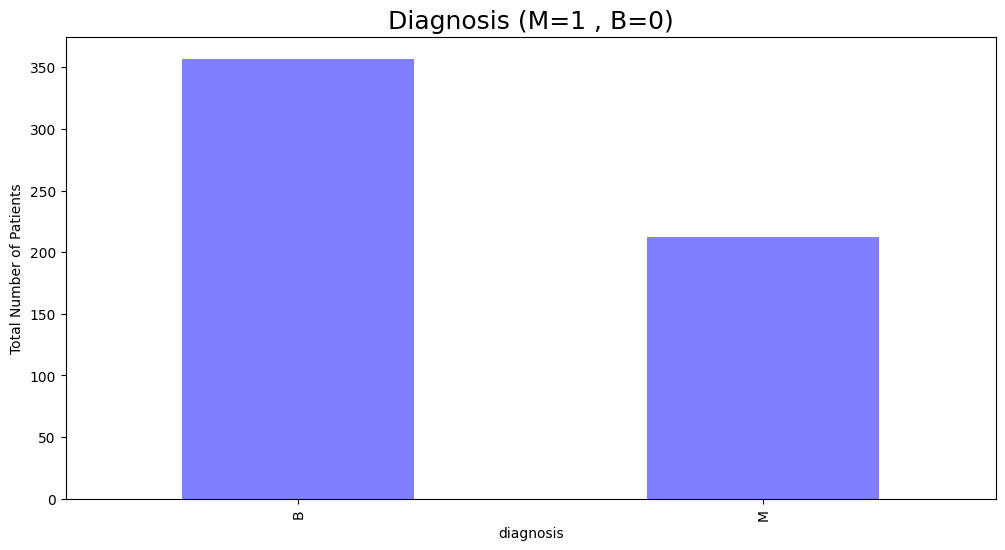

In [5]:
#Looking at the number of patients with Malignant and Benign Tumors:
y.value_counts().plot(kind='bar', alpha = 0.5, facecolor = 'b', figsize=(12,6))
plt.title("Diagnosis (M=1 , B=0)", fontsize = '18')
plt.ylabel("Total Number of Patients")


# Data Preprocessing
Before training models, we:
1. Handle missing values using mean imputation.
2. Scale features using `StandardScaler` for consistent ranges.
3. Encode the target variable to numeric form (`B=0, M=1`).
4. Split the dataset into training (80%) and test sets (20%) while preserving class distribution.


In [6]:

# Preprocessing

# 0. Drop useless columns first
X_clean = X.drop(columns=['id'])            # remove ID
X_clean = X_clean.dropna(axis=1, how='all') # remove columns like 'Unnamed: 32'

# 1. Handle missing values
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X_clean)

# 2. Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 3. Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # B=0, M=1

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)


In [7]:
print(len(X_clean.columns))

30


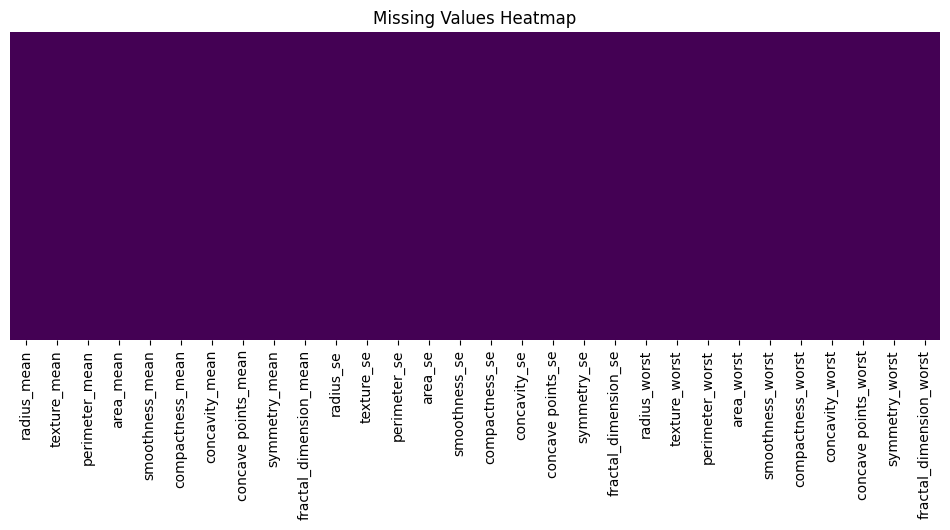

In [8]:

# Missing values heatmap
plt.figure(figsize=(12,4))
sns.heatmap(X_clean.isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


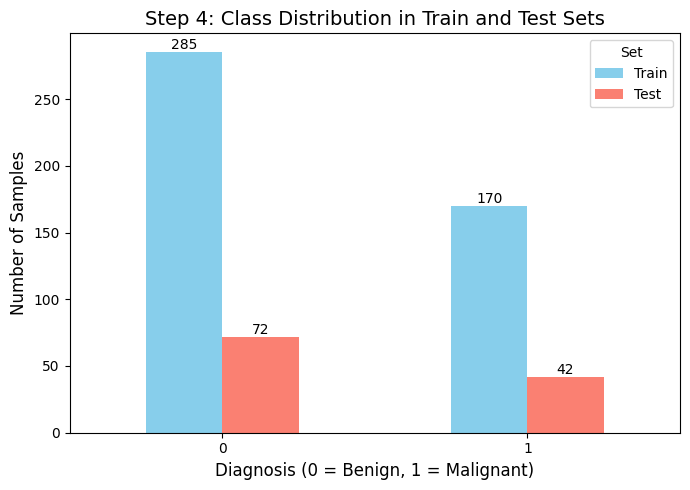

In [9]:

# Train-Test Split Distribution

# Count classes
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

# Combine into DataFrame
df_split = pd.DataFrame({'Train': train_counts, 'Test': test_counts})

# Plot
ax = df_split.plot(kind='bar', figsize=(7,5), color=['skyblue','salmon'])
plt.title("Step 4: Class Distribution in Train and Test Sets", fontsize=14)
plt.xlabel("Diagnosis (0 = Benign, 1 = Malignant)", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(rotation=0)

# Add counts on top of bars
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.legend(title="Set")
plt.tight_layout()
plt.show()


# Baseline Random Forest
We train a default Random Forest classifier and evaluate it using 5-fold cross-validation.
This gives a baseline performance before hyperparameter tuning.


In [ ]:
# Initialize default Random Forest
rf_baseline = RandomForestClassifier(random_state = 42)

# 5-fold cross-validation on training set
cv_scores_baseline = cross_val_score(rf_baseline, X_train, y_train, cv=5, scoring='recall')
print("Baseline CV scores:", cv_scores_baseline)
print("Baseline Mean CV recall:", cv_scores_baseline.mean())

# Fit on training and evaluate on test set : Before tuning
rf_baseline.fit(X_train, y_train)
y_pred_baseline = rf_baseline.predict(X_test)
baseline_test_acc = accuracy_score(y_test, y_pred_baseline)
print("Baseline Test Accuracy:", baseline_test_acc)


Baseline CV scores: [1.         0.97058824 0.88235294 0.94117647 0.91176471]
Baseline Mean CV recall: 0.9411764705882353
Baseline Test Accuracy: 0.956140350877193


In [14]:
# Print the hyperparameters of the baseline Random Forest
print("Baseline RF hyperparameters:")
print(rf_baseline.get_params())


Baseline RF hyperparameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


# Hyperparameter Tuning

We perform a Grid Search with 5-fold cross-validation to find the optimal hyperparameters for the Random Forest.  

For this dataset, detecting malignant tumors is critical, so we use **recall** as the main metric to select the best model.  

By tuning the hyperparameters, the model can **generalize better** to unseen data and improve its ability to correctly identify malignant cases.


In [ ]:

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 700, 1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced'],
    'max_features': ['sqrt', 'log2'],
    
}


# Grid Search with 5-fold CV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

# Fit GridSearch
grid_search.fit(X_train, y_train)



,estimator,RandomForestClassifier()
,param_grid,"{'class_weight': ['balanced'], 'max_depth': [None], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [2], ...}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [16]:

# Best Hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
print("Best CV Recall:", grid_search.best_score_)


# Evaluate on Test Set
best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)
tuned_test_acc = accuracy_score(y_test, y_pred_tuned)
print("Tuned Test Accuracy:", tuned_test_acc)

Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Recall: 0.9411764705882353
Tuned Test Accuracy: 0.9736842105263158


# Model Evaluation: Baseline vs Tuned Random Forest


## Cumulative Model Evaluation

This section introduces a **unified evaluation function** to compare multiple models on both **training** and **test** sets. It produces:

1. **Confusion matrices** for each model (train and test).  
2. **ROC curves** for all models on the train and test datasets.  
3. **Precision-Recall curves** for all models on the train and test datasets.  
4. A **metrics table** showing Accuracy, Precision, Recall, F1-score, and AUC for both train and test sets side by side.

The function accepts:
- `models`: a list of trained model objects.
- `model_names`: corresponding names of the models (for labeling plots).
- `X_train`, `y_train`, `X_test`, `y_test`: the datasets for evaluation.




## Training Set Performance

We first evaluated the **baseline Random Forest** and the **tuned Random Forest** on the training set:

- **Metrics evaluated:** Accuracy, Precision, Recall, F1-score
- Purpose: Check if the models learned the training data well and if there is overfitting.



## Test Set Performance

Next, we tested both models on the **hold-out test set**:

- Evaluated the same metrics as the training set.
- Purpose: Assess generalization performance and how the model will perform on unseen data.





In [17]:
def evaluate_models(models, names, X_train_list, y_train, X_test_list, y_test):
    """
    Evaluate multiple models, each possibly with its own feature subset.

    Produces:
    - Separate tables for train and test metrics
    - ROC curves for train and test
    - Precision-Recall curves for train and test
    - Confusion matrices (Test set)

    Parameters
    ----------
    models : list
        List of trained models
    names : list
        Names of models
    X_train_list : list
        List of X_train arrays/dataframes corresponding to each model
    y_train : array
        True training labels
    X_test_list : list
        List of X_test arrays/dataframes corresponding to each model
    y_test : array
        True test labels

    Returns
    -------
    train_metrics_df : pd.DataFrame
        Metrics table for training set
    test_metrics_df : pd.DataFrame
        Metrics table for test set
    """

    train_metrics = []
    test_metrics = []

    # Prepare plots
    _, ax_roc = plt.subplots(1,2, figsize=(14,6))
    _, ax_pr = plt.subplots(1,2, figsize=(14,6))
    _, axes_cm = plt.subplots(1,len(models), figsize=(5*len(models),5))
    if len(models) == 1:
        axes_cm = [axes_cm]

    for i, model in enumerate(models):
        X_tr = X_train_list[i]
        X_te = X_test_list[i]

        # --- Training metrics ---
        y_train_pred = model.predict(X_tr)
        y_train_proba = model.predict_proba(X_tr)[:,1] if hasattr(model, "predict_proba") else None

        train_metrics.append({
            "Model": names[i],
            "Accuracy": accuracy_score(y_train, y_train_pred),
            "Precision": precision_score(y_train, y_train_pred),
            "Recall": recall_score(y_train, y_train_pred),
            "F1": f1_score(y_train, y_train_pred),
            "AUC": roc_auc_score(y_train, y_train_proba) if y_train_proba is not None else None
        })

        # ROC curve (train)
        if y_train_proba is not None:
            fpr, tpr, _ = roc_curve(y_train, y_train_proba)
            ax_roc[0].plot(fpr, tpr, label=f"{names[i]} (AUC={roc_auc_score(y_train, y_train_proba):.3f})")

        # PR curve (train)
        if y_train_proba is not None:
            prec_curve, rec_curve, _ = precision_recall_curve(y_train, y_train_proba)
            ax_pr[0].plot(rec_curve, prec_curve, label=f"{names[i]}")

        # --- Test metrics ---
        y_test_pred = model.predict(X_te)
        y_test_proba = model.predict_proba(X_te)[:,1] if hasattr(model, "predict_proba") else None

        test_metrics.append({
            "Model": names[i],
            "Accuracy": accuracy_score(y_test, y_test_pred),
            "Precision": precision_score(y_test, y_test_pred),
            "Recall": recall_score(y_test, y_test_pred),
            "F1": f1_score(y_test, y_test_pred),
            "AUC": roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None
        })

        # ROC curve (test)
        if y_test_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_test_proba)
            ax_roc[1].plot(fpr, tpr, label=f"{names[i]} (AUC={roc_auc_score(y_test, y_test_proba):.3f})")

        # PR curve (test)
        if y_test_proba is not None:
            prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_test_proba)
            ax_pr[1].plot(rec_curve, prec_curve, label=f"{names[i]}")

        # Confusion matrix (Test set)
        cm = confusion_matrix(y_test, y_test_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes_cm[i])
        axes_cm[i].set_title(f"{names[i]} (Test)")
        axes_cm[i].set_xlabel("Predicted")
        axes_cm[i].set_ylabel("Actual")

    # Finalize ROC plots
    for ax, title in zip(ax_roc, ["Train ROC", "Test ROC"]):
        ax.plot([0,1],[0,1],'k--')
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(title)
        ax.legend()
        ax.grid(True)

    # Finalize PR plots
    for ax, title in zip(ax_pr, ["Train PR", "Test PR"]):
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_title(title)
        ax.legend()
        ax.grid(True)

    plt.show()

    # Convert metrics to DataFrames
    train_metrics_df = pd.DataFrame(train_metrics).set_index("Model")
    test_metrics_df = pd.DataFrame(test_metrics).set_index("Model")

    print("=== Training Set Metrics ===")
    display(train_metrics_df)
    print("\n=== Test Set Metrics ===")
    display(test_metrics_df)



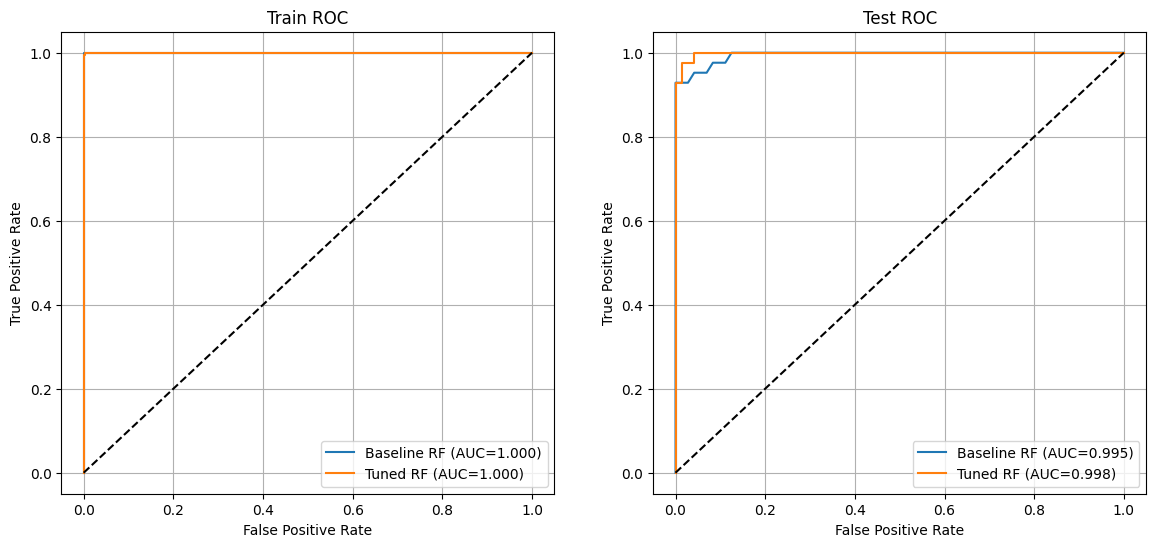

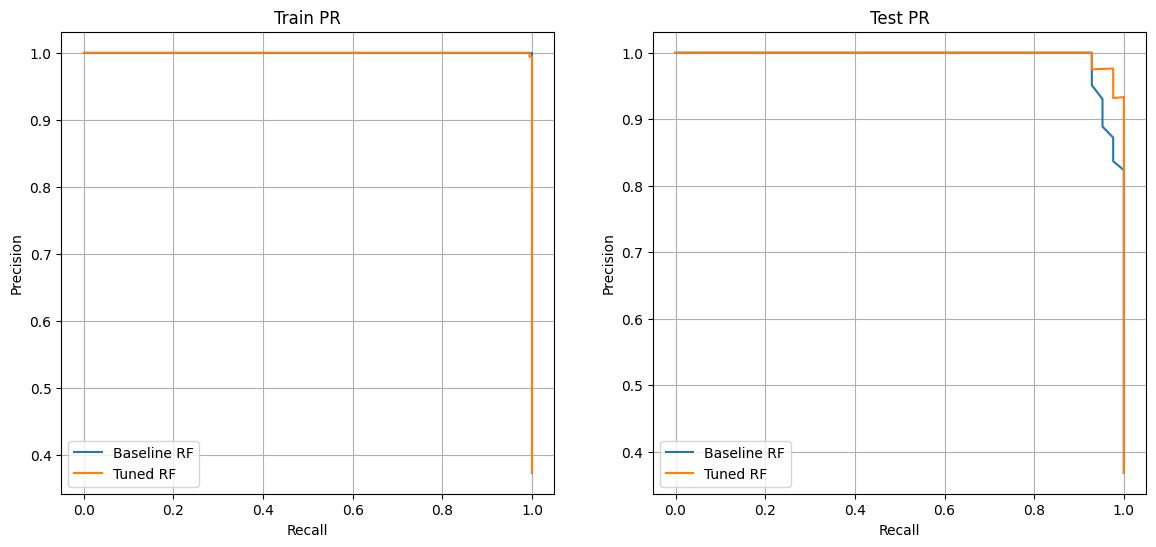

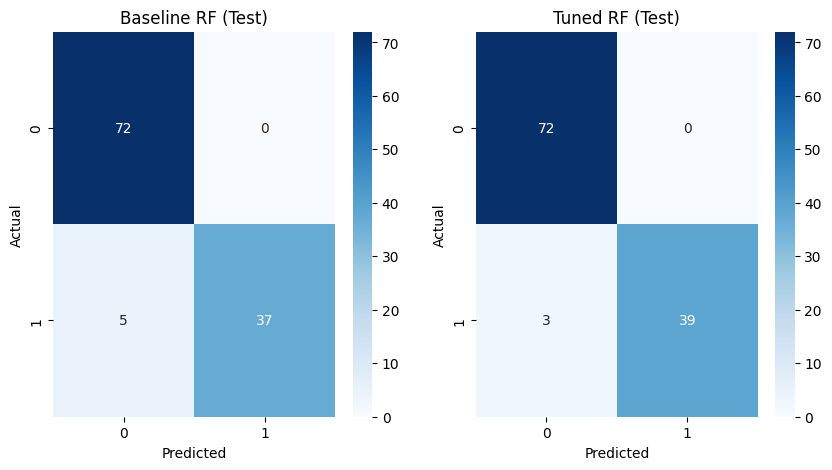

=== Training Set Metrics ===


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Baseline RF,1.000000,1.0,1.000000,1.000000,1.000000
Tuned RF,0.995604,1.0,0.988235,0.994083,0.999979



=== Test Set Metrics ===


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Baseline RF,0.956140,1.0,0.880952,0.936709,0.994544
Tuned RF,0.973684,1.0,0.928571,0.962963,0.998347


In [18]:
models = [rf_baseline, best_rf]
names = ["Baseline RF", "Tuned RF"]
X_train_list = [X_train, X_train]
X_test_list  = [X_test, X_test]
evaluate_models(models, names, X_train_list, y_train, X_test_list, y_test)



## Decision Tree Visualization

- We visualized **one tree from the tuned Random Forest** to interpret how decisions are made.
- Early splits highlight the most important features (e.g., radius, concavity, area).
- While a single tree is not the full model, it provides interpretability and insights into feature importance.

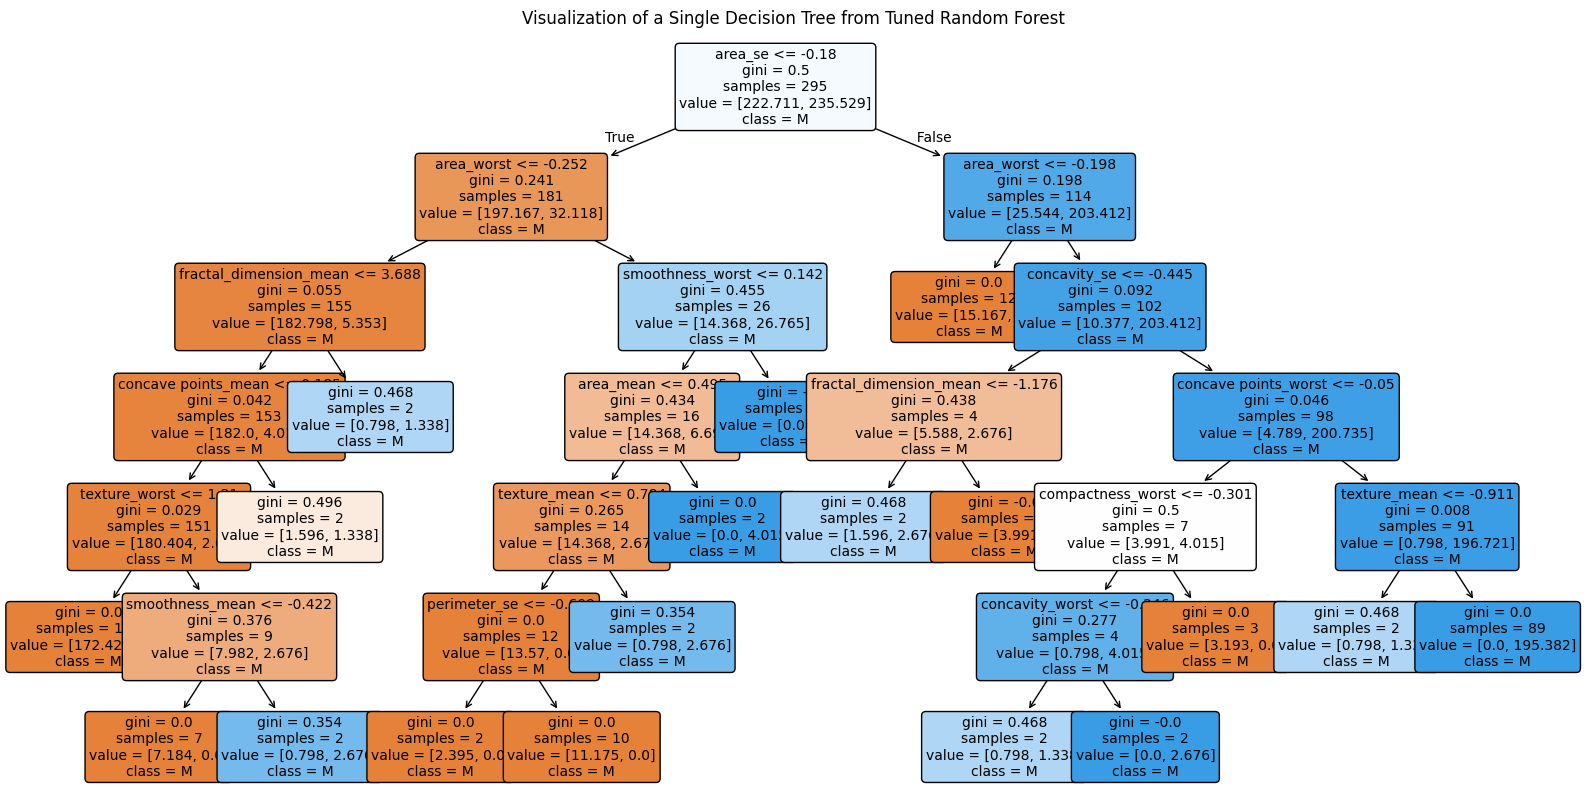

In [19]:
# Pick the first tree from the tuned Random Forest
estimator = best_rf.estimators_[0]

# Plot the tree
plt.figure(figsize=(20,10))  # large figure for readability
plot_tree(
    estimator,
    feature_names=X_clean.columns,                     # feature names
    class_names=y,  # 'malignant' and 'benign'
    filled=True,                                # color nodes by class
    rounded=True,                               # rounded boxes
    fontsize=10
)
plt.title("Visualization of a Single Decision Tree from Tuned Random Forest")
plt.show()


# Performance Improvement Requirements

## Feature Importance and Selection
We extract feature importances from the tuned Random Forest, rank them, and select the top 10 features.
We retrain the Random Forest using only these top features to check if performance improves.


In [20]:
print(len(best_rf.feature_importances_))
print(len(X_clean.columns))

30
30


In [ ]:

# Convert NumPy arrays back to DataFrames
# Keep column names from X_clean
X_train_df = pd.DataFrame(X_train, columns=X_clean.columns)
X_test_df = pd.DataFrame(X_test, columns=X_clean.columns)


# Feature Importances
importances = best_rf.feature_importances_
feat_imp_df = pd.DataFrame({
    'feature': X_clean.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# print("Feature importances:\n", feat_imp_df)


#  Select Top 10 Features
top_features = feat_imp_df['feature'].head(10).values
print("Top 10 features:", top_features)

X_train_selected = X_train_df[top_features]
X_test_selected = X_test_df[top_features]


# Retrain Random Forest on Top Features
rf_selected = RandomForestClassifier(**best_params, random_state = 42)
rf_selected.fit(X_train_selected, y_train)


Top 10 features: ['radius_worst' 'area_worst' 'concave points_mean' 'perimeter_worst'
 'concave points_worst' 'radius_mean' 'perimeter_mean' 'area_se'
 'concavity_worst' 'area_mean']


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


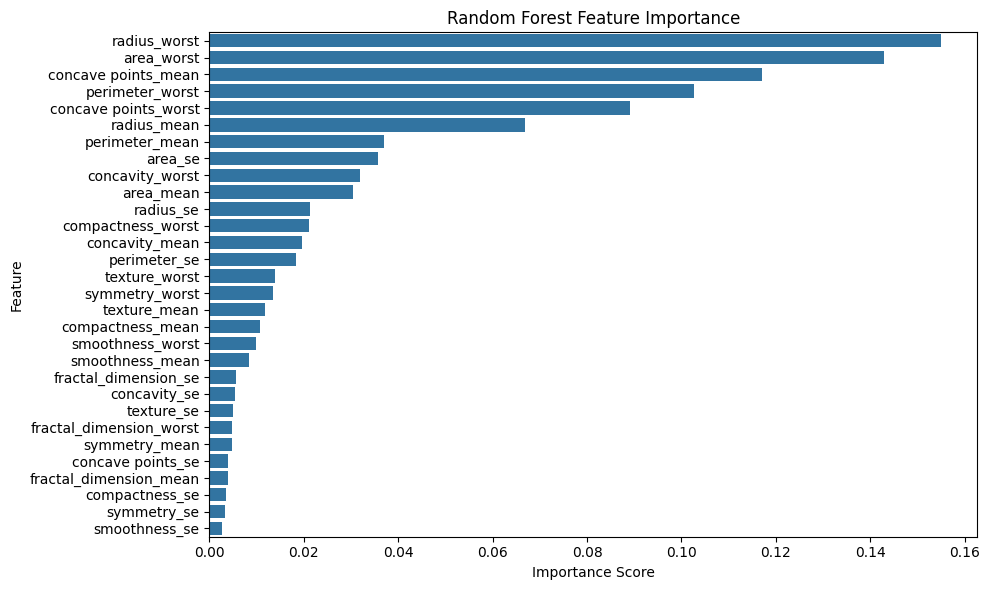

In [22]:
# Feature importance from best RF
feat_imp_df = pd.DataFrame({
    'feature': X_clean.columns,
    'importance': best_rf.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


/tmp/ipykernel_7297/2046823156.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp_df['importance'].head(10), y=top_features, palette="viridis")


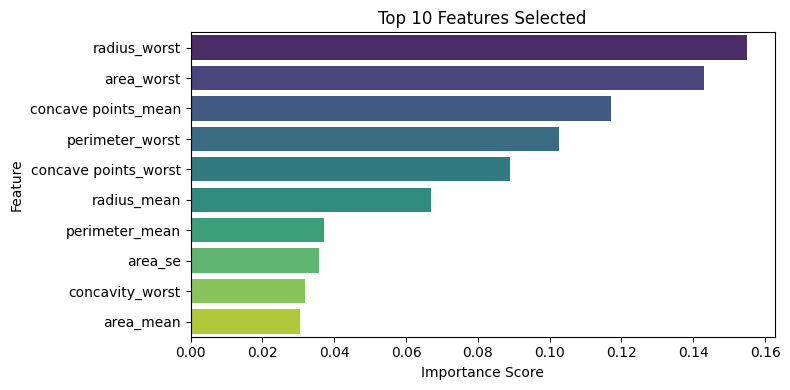

In [23]:
top_features = feat_imp_df['feature'].head(10).values
plt.figure(figsize=(8,4))
sns.barplot(x=feat_imp_df['importance'].head(10), y=top_features, palette="viridis")
plt.title("Top 10 Features Selected")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


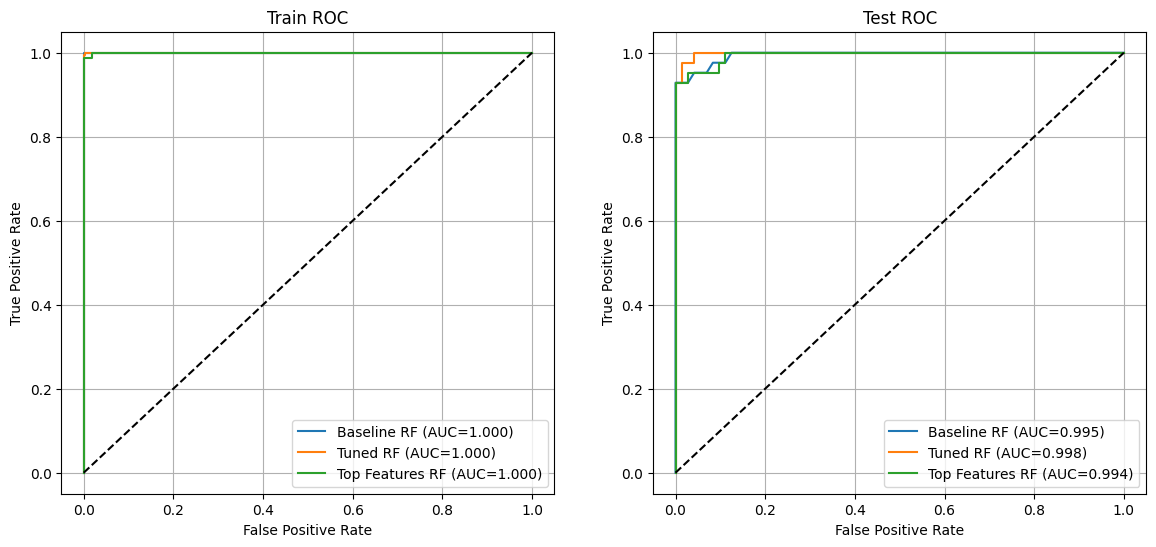

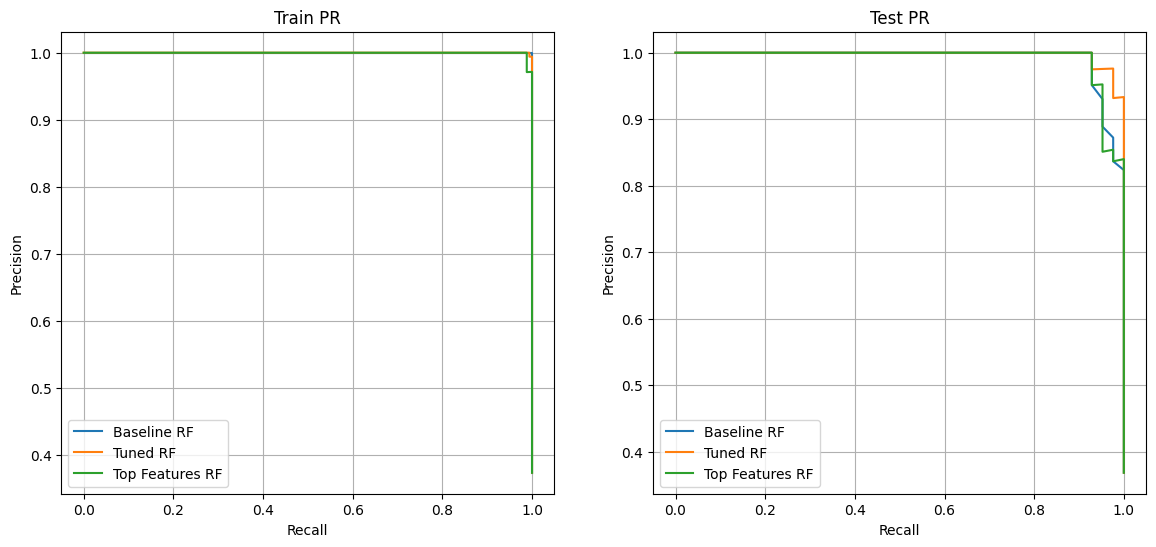

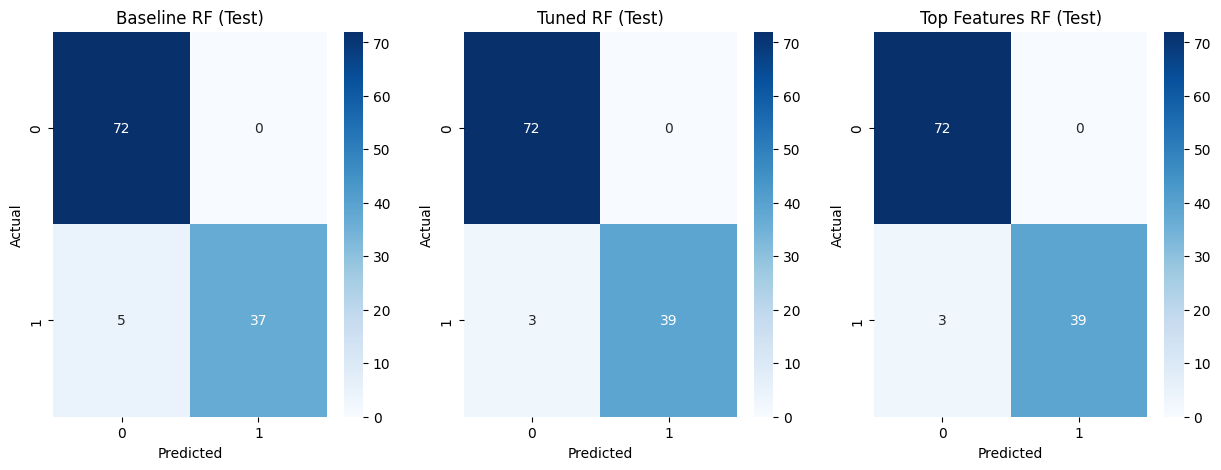

=== Training Set Metrics ===


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Baseline RF,1.000000,1.0,1.000000,1.000000,1.000000
Tuned RF,0.995604,1.0,0.988235,0.994083,0.999979
Top Features RF,0.995604,1.0,0.988235,0.994083,0.999794



=== Test Set Metrics ===


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Baseline RF,0.956140,1.0,0.880952,0.936709,0.994544
Tuned RF,0.973684,1.0,0.928571,0.962963,0.998347
Top Features RF,0.973684,1.0,0.928571,0.962963,0.994378


In [30]:
models = [rf_baseline, best_rf, rf_selected]
names = ["Baseline RF", "Tuned RF", "Top Features RF"]


X_train_list = [X_train, X_train, X_train_selected]
X_test_list  = [X_test, X_test,X_test_selected]
evaluate_models(models, names, X_train_list, y_train, X_test_list, y_test)



## Ensemble Learning
We add two different ensemble strategies using our tuned Random Forest:

1. **Random Forest + Gradient Boosting** (soft voting ensemble)  
2. **Random Forest + AdaBoost** (soft voting ensemble)

Metrics used: Accuracy, Precision, Recall, F1-score, ROC-AUC, and confusion matrices.



In [31]:
# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
rf = best_rf  # tuned Random Forest

# Soft voting ensemble
ensemble = VotingClassifier(estimators=[('rf', rf), ('gb', gb)], voting='soft', n_jobs=-1)
ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)

print("Recall of RF + GB Ensemble:", recall_score(y_test, y_pred_ensemble))
print("Accuracy of RF + GB Ensemble:", accuracy_score(y_test, y_pred_ensemble))



Recall of RF + GB Ensemble: 0.9047619047619048
Accuracy of RF + GB Ensemble: 0.9649122807017544


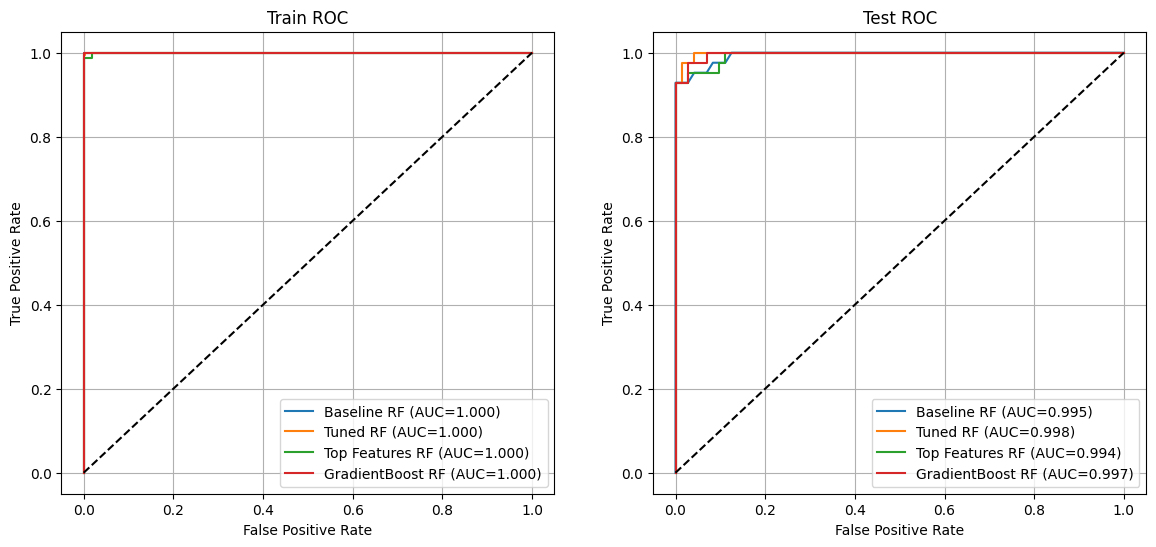

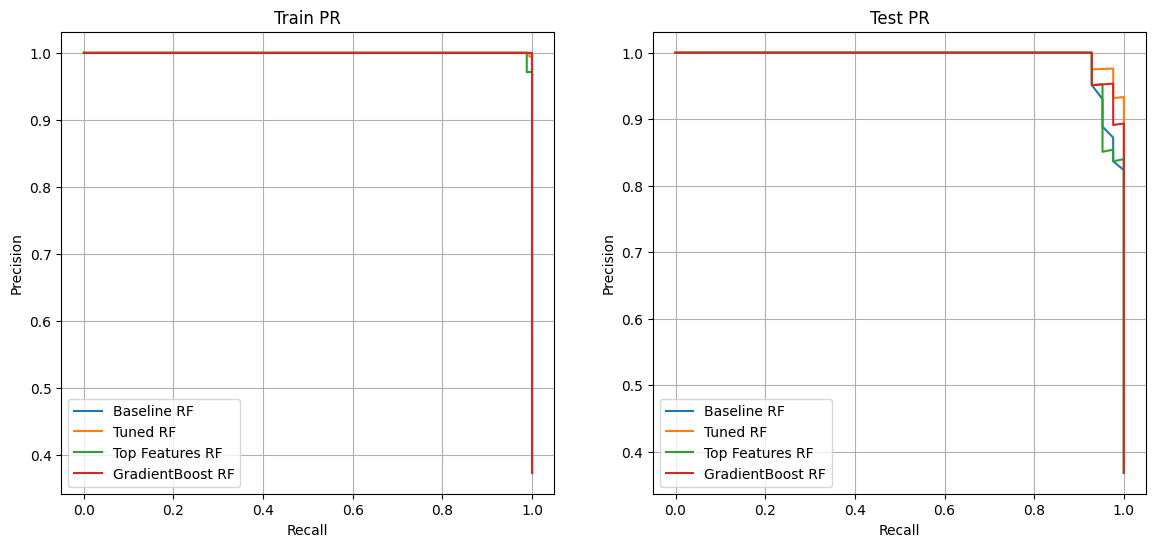

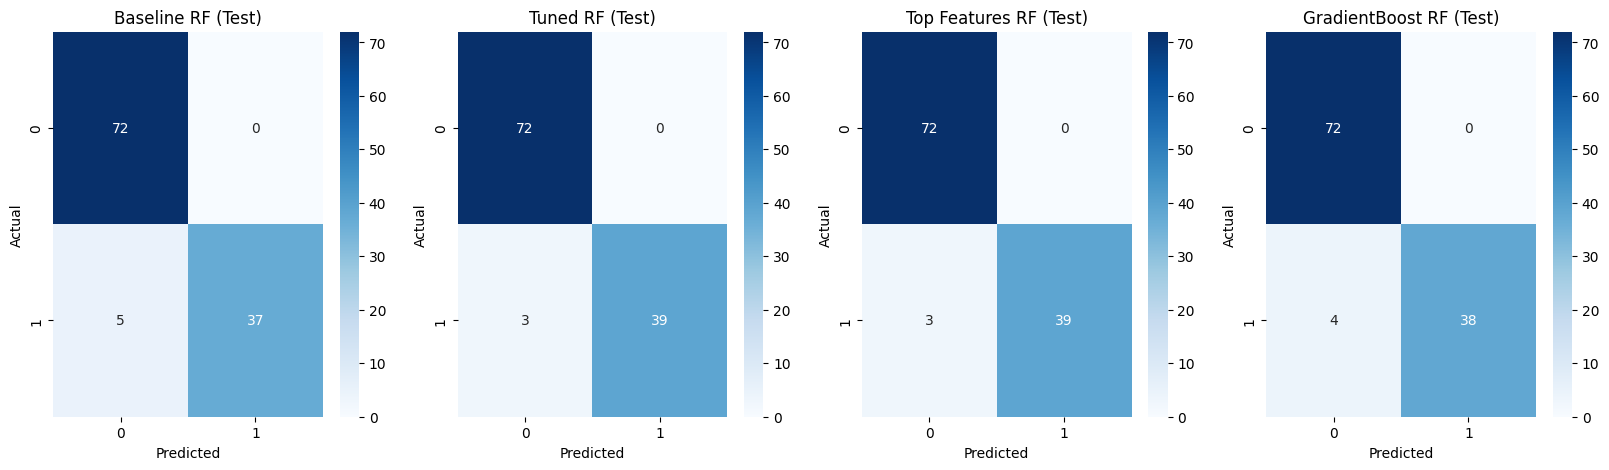

=== Training Set Metrics ===


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Baseline RF,1.000000,1.0,1.000000,1.000000,1.000000
Tuned RF,0.995604,1.0,0.988235,0.994083,0.999979
Top Features RF,0.995604,1.0,0.988235,0.994083,0.999794
GradientBoost RF,1.000000,1.0,1.000000,1.000000,1.000000



=== Test Set Metrics ===


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Baseline RF,0.956140,1.0,0.880952,0.936709,0.994544
Tuned RF,0.973684,1.0,0.928571,0.962963,0.998347
Top Features RF,0.973684,1.0,0.928571,0.962963,0.994378
GradientBoost RF,0.964912,1.0,0.904762,0.950000,0.997024


In [33]:
models = [rf_baseline, best_rf, rf_selected, ensemble]
names = ["Baseline RF", "Tuned RF", "Top Features RF",  "GradientBoost RF"]


X_train_list = [X_train, X_train, X_train_selected, X_train]
X_test_list  = [X_test, X_test,X_test_selected, X_test]
metrics_df = evaluate_models(models, names, X_train_list, y_train, X_test_list, y_test)


In [ ]:
#  AdaBoost
ada = AdaBoostClassifier(n_estimators=200, learning_rate=1.0, random_state=42)

# Ensemble with tuned RF + AdaBoost
ensemble_rf_ada = VotingClassifier(
    estimators=[('rf', best_rf), ('ada', ada)],
    voting='soft',
    n_jobs=-1
)

ensemble_rf_ada.fit(X_train, y_train)
y_pred_ensemble_rf_ada = ensemble_rf_ada.predict(X_test)


print("Recall of RF + Ada boost Ensemble:", recall_score(y_test, y_pred_ensemble_rf_ada))
print("Accuracy of RF + Ada boost Ensemble:", accuracy_score(y_test, y_pred_ensemble_rf_ada))


Recall of RF + Ada boost Ensemble: 0.9285714285714286
Accuracy of RF + Ada boost Ensemble: 0.9736842105263158


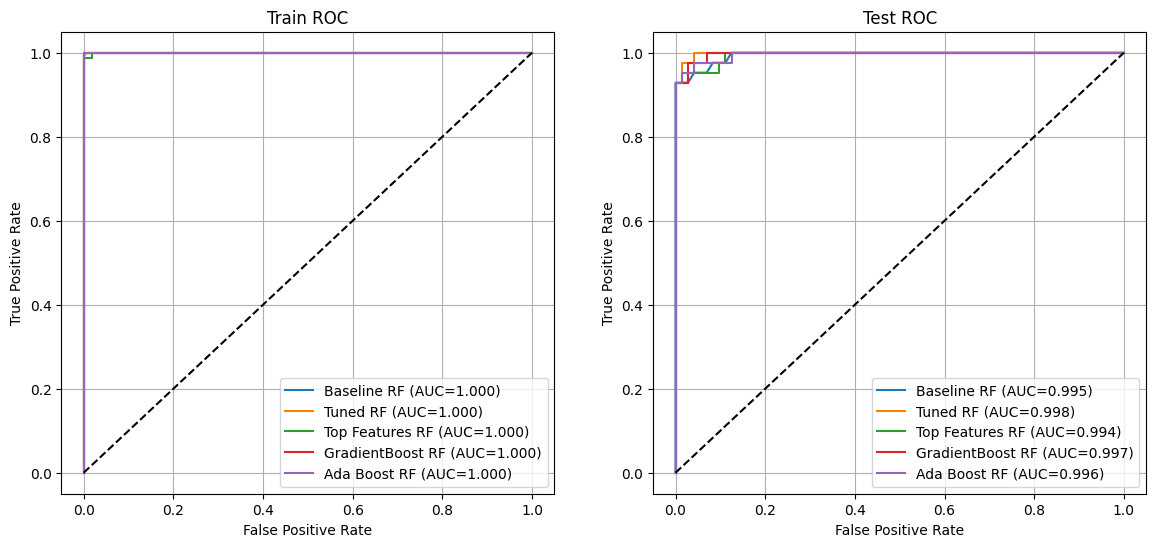

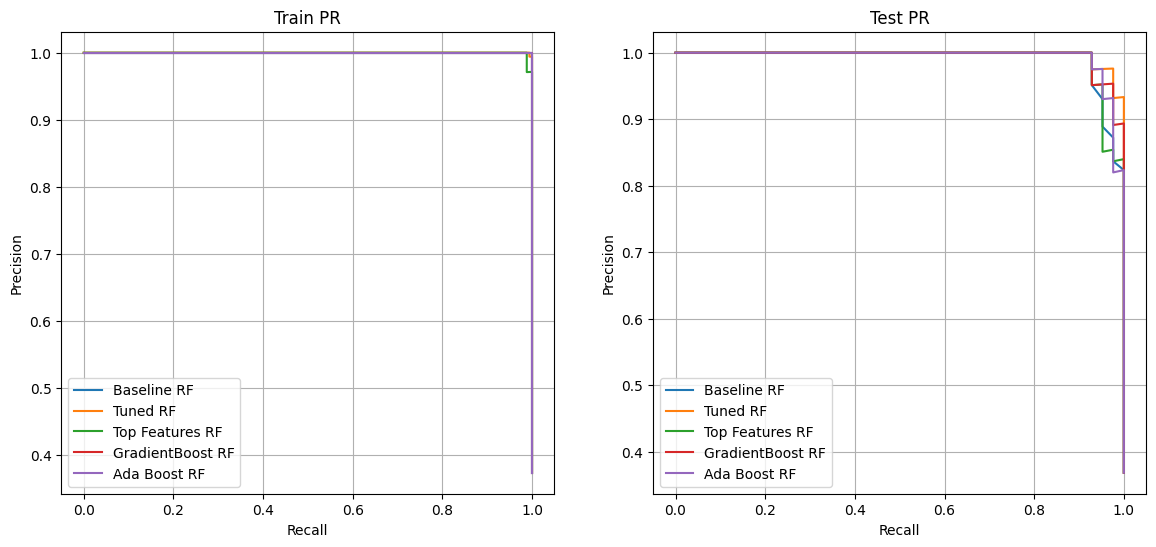

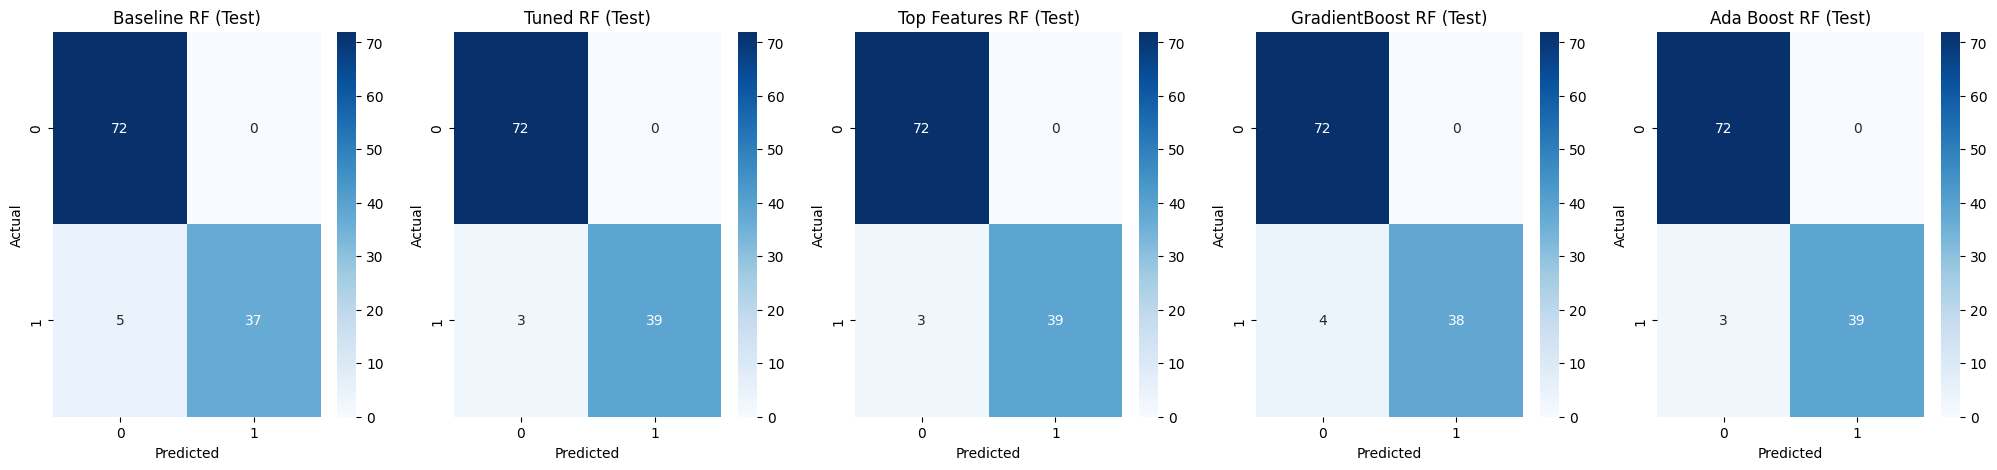

=== Training Set Metrics ===


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Baseline RF,1.000000,1.0,1.000000,1.000000,1.000000
Tuned RF,0.995604,1.0,0.988235,0.994083,0.999979
Top Features RF,0.995604,1.0,0.988235,0.994083,0.999794
GradientBoost RF,1.000000,1.0,1.000000,1.000000,1.000000
Ada Boost RF,0.997802,1.0,0.994118,0.997050,1.000000



=== Test Set Metrics ===


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Baseline RF,0.956140,1.0,0.880952,0.936709,0.994544
Tuned RF,0.973684,1.0,0.928571,0.962963,0.998347
Top Features RF,0.973684,1.0,0.928571,0.962963,0.994378
GradientBoost RF,0.964912,1.0,0.904762,0.950000,0.997024
Ada Boost RF,0.973684,1.0,0.928571,0.962963,0.995701


In [36]:
models = [rf_baseline, best_rf, rf_selected, ensemble, ensemble_rf_ada]
names = ["Baseline RF", "Tuned RF", "Top Features RF",  "GradientBoost RF", "Ada Boost RF"]


X_train_list = [X_train, X_train, X_train_selected, X_train, X_train]
X_test_list  = [X_test, X_test,X_test_selected, X_test, X_test]
evaluate_models(models, names, X_train_list, y_train, X_test_list, y_test)


## Handling Class Imbalance with SMOTE
SMOTE (Synthetic Minority Oversampling Technique) is used to balance the dataset by generating synthetic samples of the minority class.
We retrain the Random Forest on this balanced dataset and evaluate its performance.


In [ ]:
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Train Random Forest on balanced data
rf_sm = RandomForestClassifier(**best_params, random_state = 42)
rf_sm.fit(X_train_sm, y_train_sm)
y_pred_sm = rf_sm.predict(X_test)

print("Recall after SMOTE:", recall_score(y_test, y_pred_sm))
print("Accuracy after SMOTE:", accuracy_score(y_test, y_pred_sm))




Recall after SMOTE: 0.9285714285714286
Accuracy after SMOTE: 0.9736842105263158


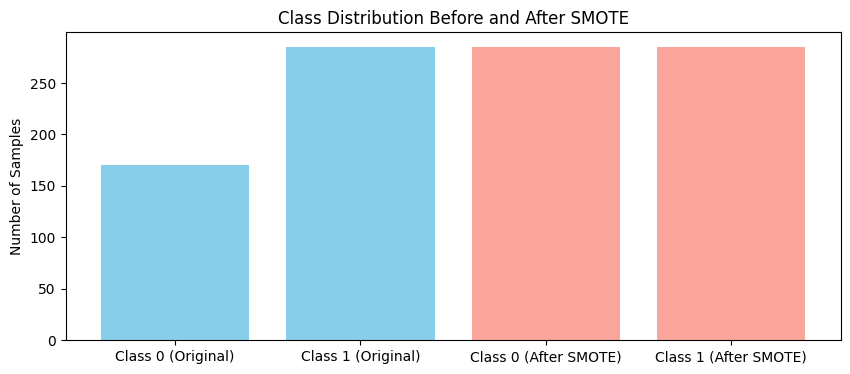

In [88]:
from collections import Counter

plt.figure(figsize=(10,4))
plt.bar(['Class 0 (Original)', 'Class 1 (Original)'], Counter(y_train).values(), color='skyblue')
plt.bar(['Class 0 (After SMOTE)', 'Class 1 (After SMOTE)'], Counter(y_train_sm).values(), color='salmon', alpha=0.7)
plt.ylabel("Number of Samples")
plt.title("Class Distribution Before and After SMOTE")
plt.show()


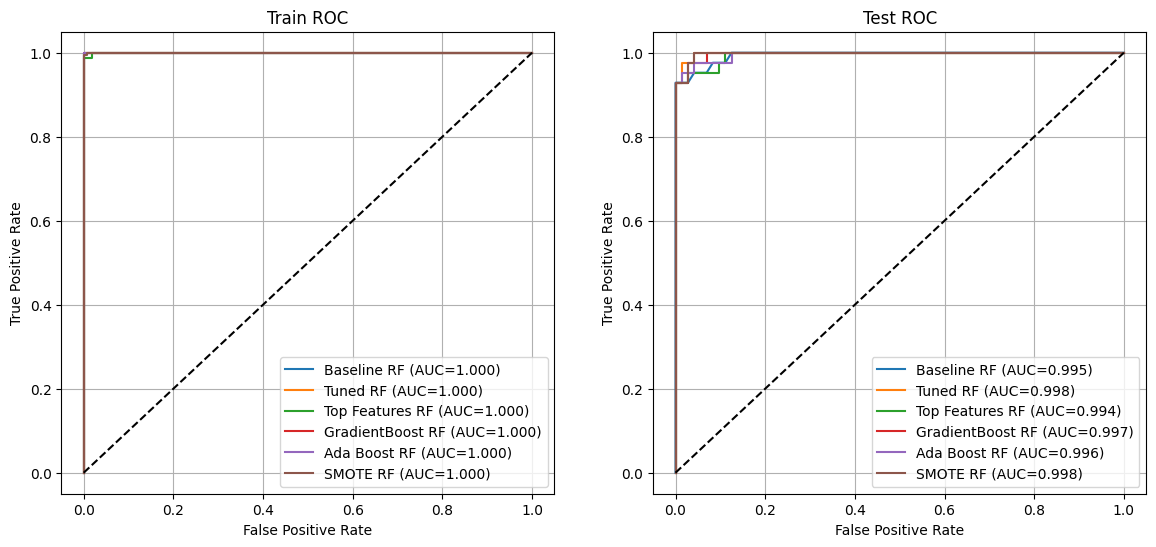

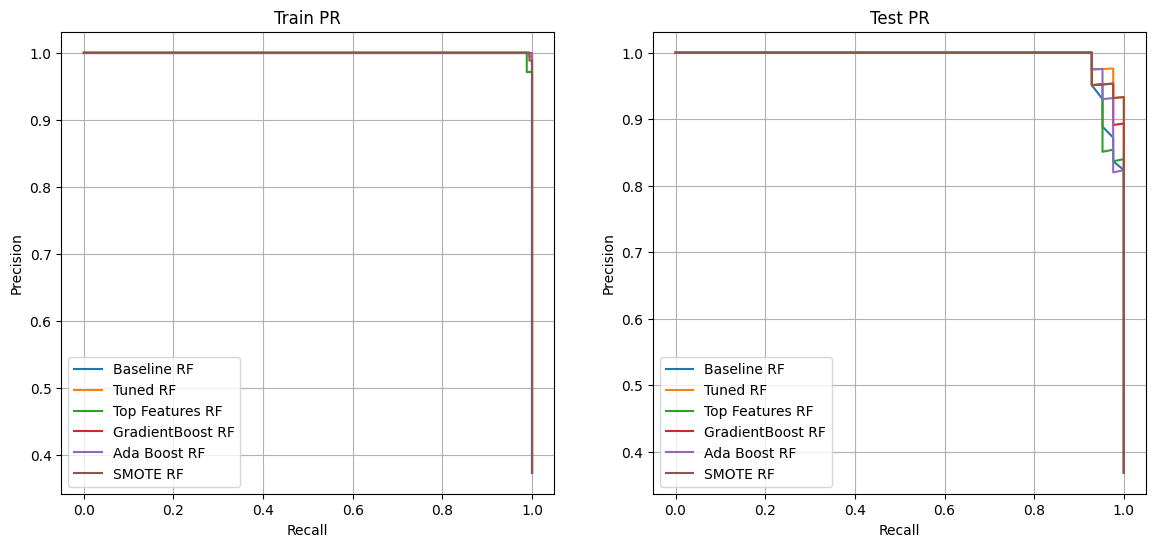

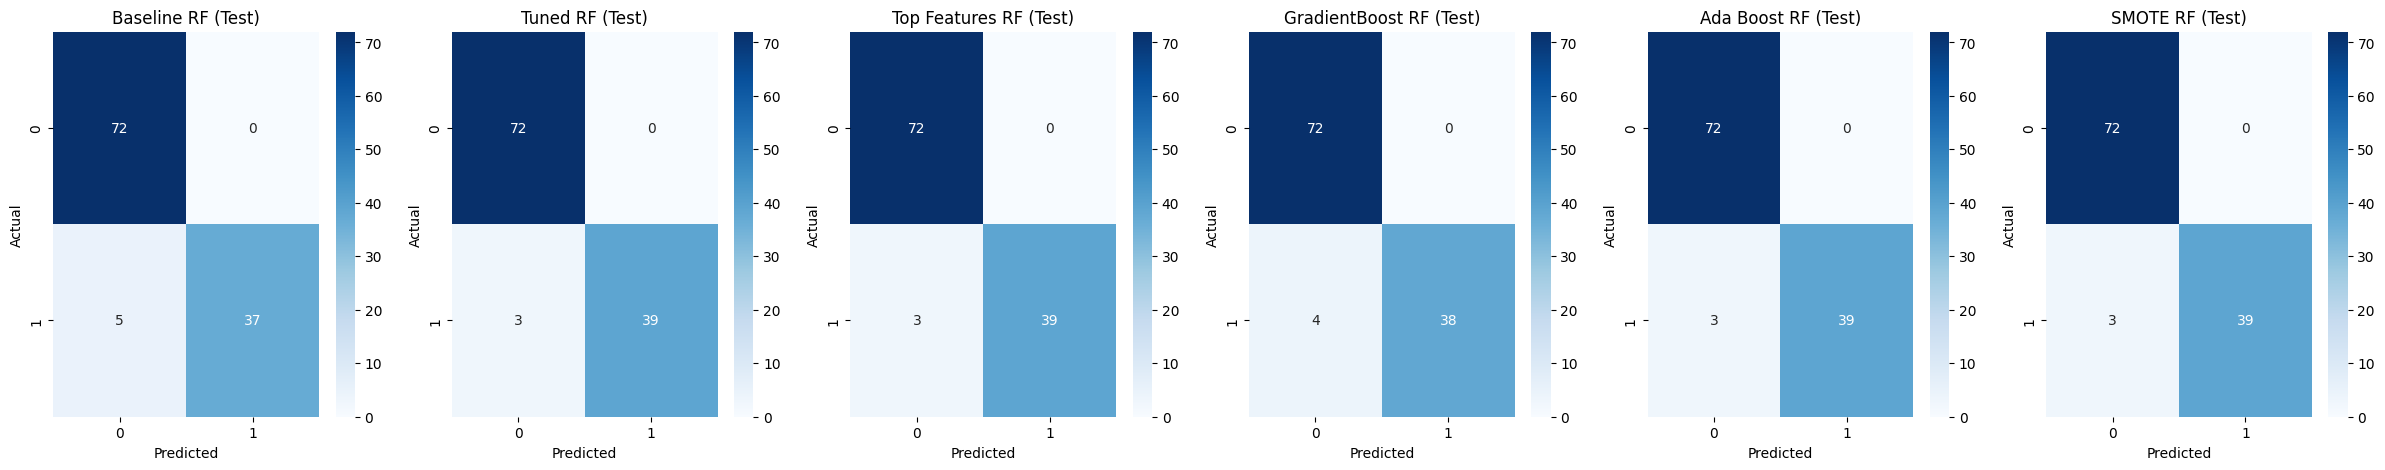

=== Training Set Metrics ===


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Baseline RF,1.000000,1.0,1.000000,1.000000,1.000000
Tuned RF,0.995604,1.0,0.988235,0.994083,0.999979
Top Features RF,0.995604,1.0,0.988235,0.994083,0.999794
GradientBoost RF,1.000000,1.0,1.000000,1.000000,1.000000
Ada Boost RF,0.997802,1.0,0.994118,0.997050,1.000000
SMOTE RF,0.995604,1.0,0.988235,0.994083,0.999959



=== Test Set Metrics ===


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Baseline RF,0.956140,1.0,0.880952,0.936709,0.994544
Tuned RF,0.973684,1.0,0.928571,0.962963,0.998347
Top Features RF,0.973684,1.0,0.928571,0.962963,0.994378
GradientBoost RF,0.964912,1.0,0.904762,0.950000,0.997024
Ada Boost RF,0.973684,1.0,0.928571,0.962963,0.995701
SMOTE RF,0.973684,1.0,0.928571,0.962963,0.997685


In [98]:
models = [rf_baseline, best_rf, rf_selected, ensemble, ensemble_rf_ada, rf_sm]
names = ["Baseline RF", "Tuned RF", "Top Features RF",  "GradientBoost RF", "Ada Boost RF", "SMOTE RF"]


X_train_list = [X_train, X_train, X_train_selected, X_train, X_train, X_train]
X_test_list  = [X_test, X_test,X_test_selected, X_test, X_test, X_test]
evaluate_models(models, names, X_train_list, y_train, X_test_list, y_test)


## Feature Engineering
We create new features to improve model performance:

1. **Ratio features** – e.g., `perimeter_mean / radius_mean`, `area_mean / radius_mean`.
2. **Difference features** – difference between worst and mean measurements (e.g., `radius_worst - radius_mean`).
3. **Standard deviation features** – standard deviation across mean, SE, and worst values for each original feature.
4. **Interaction features** – product or ratio of two important features (e.g., `concavity_mean * symmetry_mean`).
5. **Combination features** – ratios like `compactness_mean / area_mean`, products like `radius_mean * perimeter_mean`.

After feature engineering, we repeat preprocessing (imputation + scaling), train-test splitting, and model training/tuning.


In [47]:
X_clean.columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [82]:
def feature_engineering(X_df):
    X = X_df.copy()
    
    # 1. REDUCE first - pick ONE from each correlated group
    # Keep worst versions (usually most predictive for cancer)
    _ = ['radius_worst', 'area_worst']  # drop perimeter
    
    # 2. Create MEANINGFUL ratios (not mathematical identities)
    X['concavity_compactness'] = X['concavity_mean'] / (X['compactness_mean'] + 1e-6)
    X['texture_smoothness'] = X['texture_mean'] / (X['smoothness_mean'] + 1e-6)
    
    # 3. Variability features
    X['radius_variability'] = (X['radius_worst'] - X['radius_mean']) / X['radius_mean']
    X['texture_variability'] = (X['texture_worst'] - X['texture_mean']) / X['texture_mean']
    
    # 4. Drop originals we don't need
    drop_cols = ['perimeter_mean', 'perimeter_se', 'perimeter_worst',
                 'radius_mean', 'radius_se']  # keeping radius_worst
    X = X.drop(columns=drop_cols, errors='ignore')
    
    return X

In [83]:
X_fe = feature_engineering(X_clean) 
print("New feature shape:", X_fe.shape)
print("New features added:", set(X_fe.columns) - set(X_clean.columns))

New feature shape: (569, 29)
New features added: {'concavity_compactness', 'radius_variability', 'texture_smoothness', 'texture_variability'}


In [84]:
imputer = SimpleImputer(strategy="mean")
X_fe_imputed = imputer.fit_transform(X_fe)

scaler = StandardScaler()
X_fe_scaled = scaler.fit_transform(X_fe_imputed)

le = LabelEncoder()
y_fe_encoded = le.fit_transform(y)   # B=0, M=1



# 3. Train-test split (80% / 20%), stratified to preserve class ratio
X_fe_train, X_fe_test, y_fe_train, y_fe_test = train_test_split(
    X_fe_scaled, 
    y_fe_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_fe_encoded
)


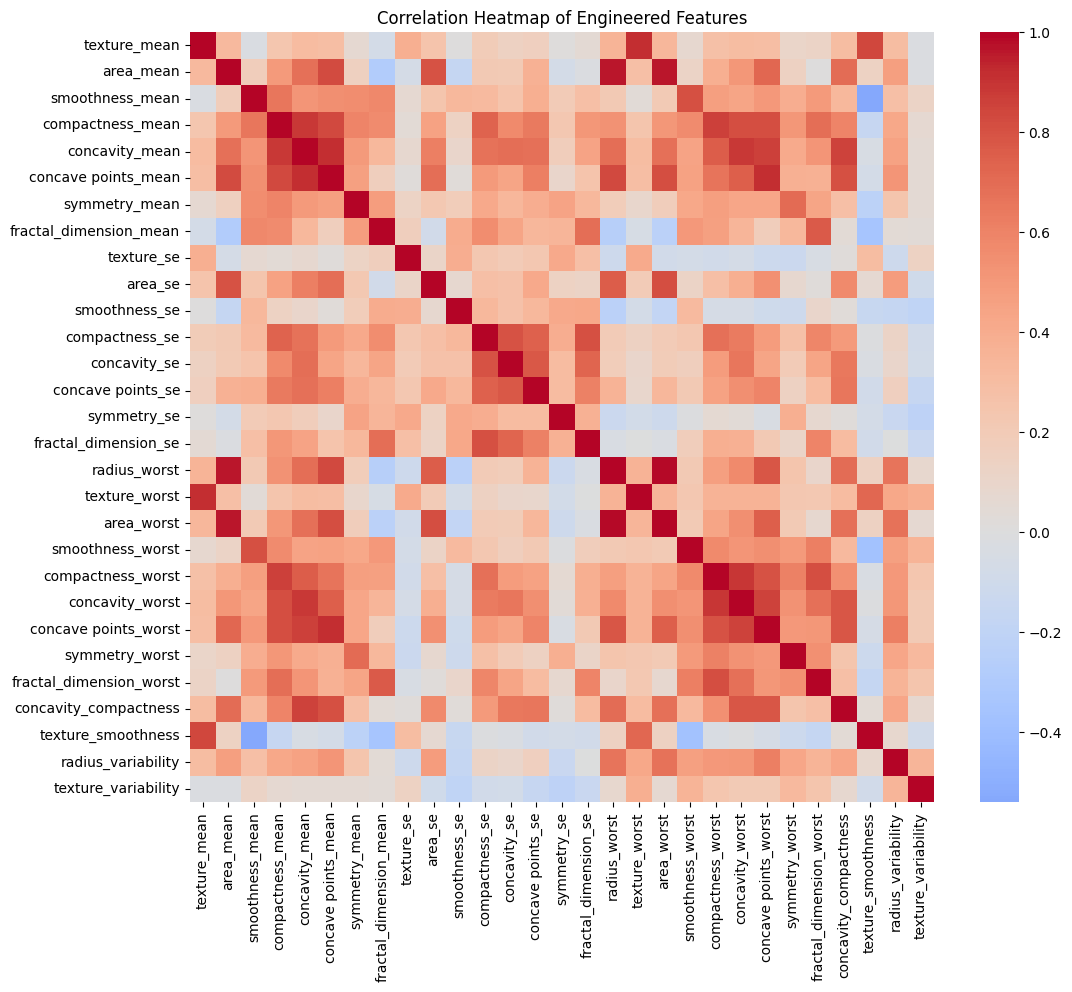

In [85]:
plt.figure(figsize=(12,10))
sns.heatmap(X_fe.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Engineered Features")
plt.show()


In [86]:
rf_fe = RandomForestClassifier(random_state=42)
rf_fe.fit(X_fe_train, y_fe_train)

y_pred_fe = rf_fe.predict(X_fe_test)

print("Recall after Feature Selection:", recall_score(y_fe_test, y_pred_fe))
print("Accuracy after Feature Selection:", accuracy_score(y_fe_test, y_pred_fe))

Recall after Feature Selection: 0.9285714285714286
Accuracy after Feature Selection: 0.9736842105263158


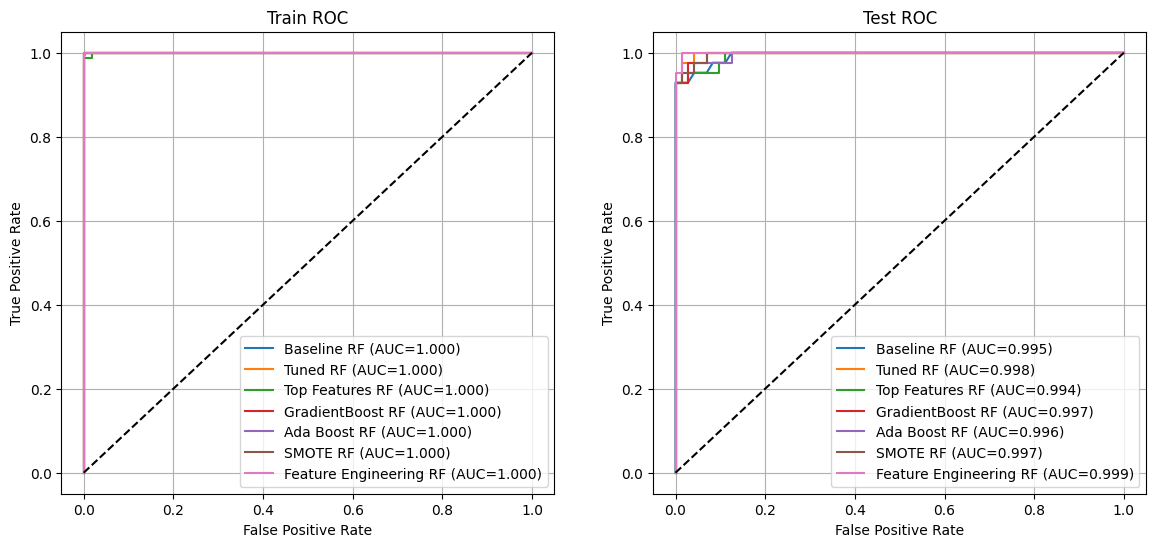

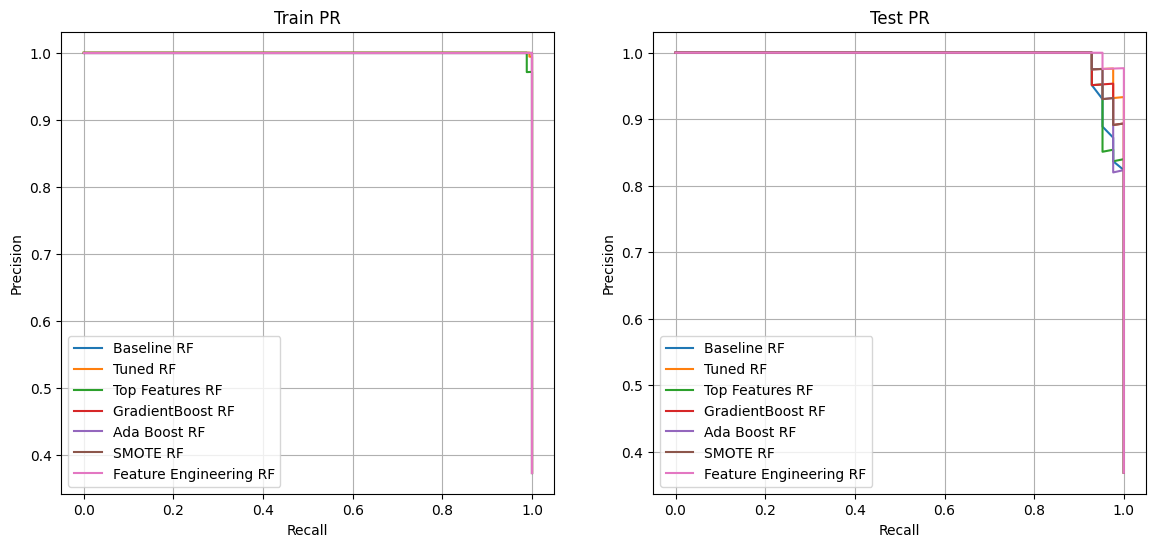

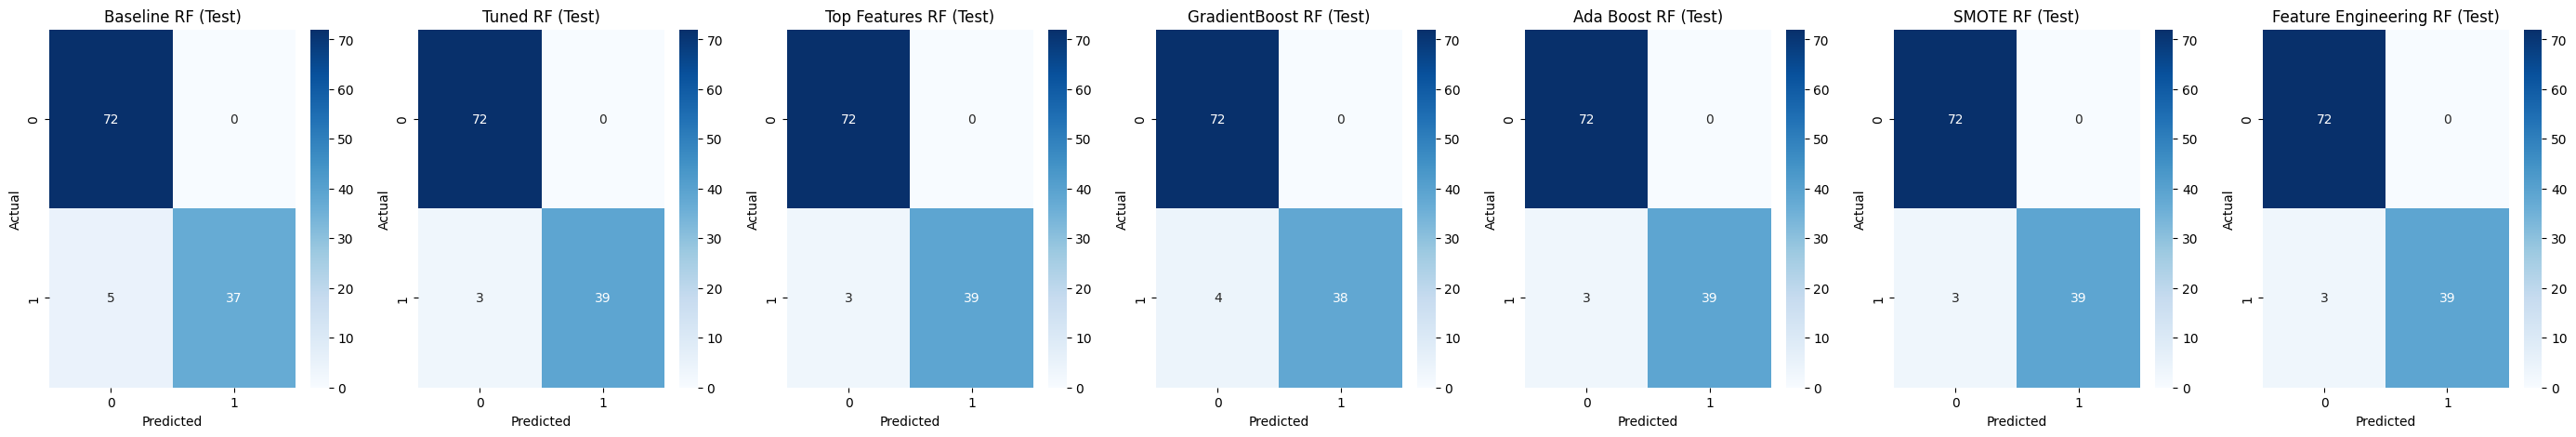

=== Training Set Metrics ===


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Baseline RF,1.000000,1.0,1.000000,1.000000,1.000000
Tuned RF,0.995604,1.0,0.988235,0.994083,0.999979
Top Features RF,0.995604,1.0,0.988235,0.994083,0.999794
GradientBoost RF,1.000000,1.0,1.000000,1.000000,1.000000
Ada Boost RF,0.997802,1.0,0.994118,0.997050,1.000000
SMOTE RF,0.997802,1.0,0.994118,0.997050,1.000000
Feature Engineering RF,1.000000,1.0,1.000000,1.000000,1.000000



=== Test Set Metrics ===


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Baseline RF,0.956140,1.0,0.880952,0.936709,0.994544
Tuned RF,0.973684,1.0,0.928571,0.962963,0.998347
Top Features RF,0.973684,1.0,0.928571,0.962963,0.994378
GradientBoost RF,0.964912,1.0,0.904762,0.950000,0.997024
Ada Boost RF,0.973684,1.0,0.928571,0.962963,0.995701
SMOTE RF,0.973684,1.0,0.928571,0.962963,0.997024
Feature Engineering RF,0.973684,1.0,0.928571,0.962963,0.999339


In [81]:
models = [rf_baseline, best_rf, rf_selected, ensemble, ensemble_rf_ada, rf_sm, rf_fe]
names  = ["Baseline RF", "Tuned RF", "Top Features RF",  "GradientBoost RF", 
          "Ada Boost RF", "SMOTE RF", "Feature Engineering RF"]

X_train_list = [X_train, X_train, X_train_selected, X_train, X_train, X_train, X_fe_train]
X_test_list  = [X_test,  X_test,  X_test_selected,  X_test,  X_test,  X_test,  X_fe_test]

evaluate_models(models, names, X_train_list, y_train, X_test_list, y_test)
